In [9]:
import os
import sys

sys.path.append('../src')

from design_gene_blocks import DesignEblocks
from design_IVA_primers import DesignPrimers
from snapgene_output import SnapGeneOutput

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# TODO INSTALL THIS IN ENVIRONMENT AND JUPYTER ENVIRONMENT (MAKE SAME ENVIRONMENT)
# !pip3 install openpyxl

In [3]:
mutations = 'files/mutations_ed.txt'
vector = 'files/snapgene_vector.dna'
gene = 'files/mtb_DnaE1_seq.txt'
output_location = 'output/'
species = 'Mycobacterium Smegmatis' # Mycobacterium Tuberculosis
codon_usage_fp = r'C:\Users\Rosan\Documents\git\my_repositories\design_gene_blocks\src\data\codon_usage'

G432E Mutation
R436Q Mutation
I451A Mutation
A484S Mutation
K562A Mutation
I569V Mutation
L584V Mutation
T595S Mutation
D599Y Mutation
P618D Mutation
N677H Mutation
Q722V Mutation
A770-PLR Insert
D773E Mutation
K922R Mutation
E972G Mutation
W973S Mutation
Q1023R Mutation
A1031T Mutation
N1034Q Mutation
N1038T Mutation
S1046N Mutation
L1052E Mutation
V1086N Mutation
R1090A Mutation
N1096E Mutation
A770
Optimizing bin sizes ...
201 325.7
202 325.7
203 517.4
204 517.4
205 482.75
206 482.75
207 482.75
208 517.4
209 517.4
210 517.4
211 517.4
212 517.4
213 517.4
214 517.4
215 517.4
216 517.4
217 517.4
218 517.4
219 517.4
220 517.4
221 517.4
222 517.4
223 517.4
224 517.4
225 517.4
226 517.4
227 517.4
228 517.4
229 517.4
230 517.4
231 553.1
232 517.4
233 517.4
234 517.4
235 517.4
236 517.4
237 517.4
238 517.4
239 517.4
240 517.4
241 517.4
242 517.4
243 517.4
244 517.4
245 517.4
246 517.4
247 517.4
248 517.4
249 517.4
250 517.4
251 517.4
252 517.4
253 517.4
254 517.4
255 517.4
256 517.4
257 517

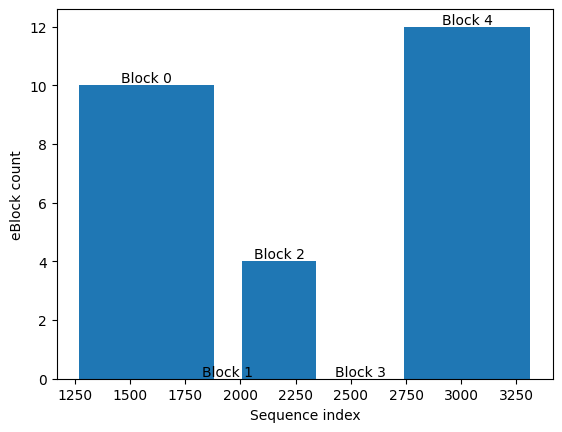

In [4]:
# Create instance of DesignEblocks

eBlocks_instance = DesignEblocks(
                        sequence_fp=gene,
                        mutations_fp=mutations,
                        output_fp=output_location,
                        species=species,
                        codon_usage_fp=codon_usage_fp)

# run eblocks design

eBlocks_instance.run()

In [5]:
# TODO DESCRIBE WHAT CAN BE SEEN IN THE PLOT

In [6]:
# DESCIBE WHAT OTHER FILES ARE CREATED



In [7]:
# DECRIBE THE NEXT STEPS

In [8]:
# Next; design IVA primers to open up destination plasmid

mut_gene_blocks_fp = os.path.join(output_location, "mut_gene_blocks.npy")
wt_gene_blocks_fp = os.path.join(output_location, "wt_gene_blocks.npy")

# Create class instance

design_primers = DesignPrimers(wt_gene_blocks_fp=wt_gene_blocks_fp, 
                               mut_gene_blocks_fp=mut_gene_blocks_fp, 
                               output_location=output_location,
                               input_gene_path=gene,
                               snapgene_file=vector)

# Design the primers

design_primers.run()

# Also write results to files that SnapGene can open
primers_fp = os.path.join(output_location, "IVA_primers.csv")
gene_blocks_mutation_info_fp = os.path.join(output_location, "gene_blocks.txt")

# If you have SnapGene installed, you can add the mutations as features in this file

snapgene_output = SnapGeneOutput(wt_gene_blocks_fp = wt_gene_blocks_fp,
                                 mut_gene_blocks_fp = mut_gene_blocks_fp,
                                 primers_fp = primers_fp,
                                 output_location = output_location,
                                 snapgene_file = vector,
                                 gene_blocks_info_fp = gene_blocks_mutation_info_fp)
snapgene_output.run()


Block_4_pos_2741_3313
Block_0_pos_1271_1879
Block_2_pos_2006_2344
The template temperatures for Fw and Rv primer of Block_4_pos_2741_3313 exceed max Tm difference 4 degrees
The overhang temperatures for Fw and Rv primer of Block_0_pos_1271_1879 exceed max Tm difference of 4 degrees
The template temperatures for Fw and Rv primer of Block_0_pos_1271_1879 exceed max Tm difference 4 degrees
The overhang temperatures for Fw and Rv primer of Block_2_pos_2006_2344 exceed max Tm difference of 4 degrees
Complementarity between the primers for Block_4_pos_2741_3313 exceeds threshold of 4
Complementarity between the primers for Block_2_pos_2006_2344 exceeds threshold of 4
Primers written to file
Make sure that primer binds nowhere else in sequence
{'Block_4_pos_2741_3313': [2755, 3327], 'Block_0_pos_1271_1879': [1285, 1893], 'Block_2_pos_2006_2344': [2020, 2358]}
1307 1309
1319 1321
1364 1366
1463 1465
1697 1699
1718 1720
1763 1765
1796 1798
1808 1810
1865 1867
2042 2044
2177 2179
2321 2323
2330 

In [ ]:
# TODO CLEANUP AND REMOVE UNNECCESSARY FILES